# 1. Analyze dataset

Load wine dataset and analyze it. The goal is to understand the features, their values and the labels.

In [382]:
import pandas as pd
import numpy as np

np.random.seed(42)

dataset = pd.read_csv('./datasets/winequality-white.csv',sep=';')

Wine dataset contains 11 numeric features and an integer label column (quality).

In [383]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Although wine labels vary from 1-9, we only see 7 values. Therefore the labels that we have are only 7 - not 9.

In [384]:
print(f'Labels: {sorted(dataset.quality.unique())}')
print(f'Label count: {len(dataset.quality.unique())}')
print(f'Min label: {dataset.quality.min()}')
print(f'Max label: {dataset.quality.max()}')

Labels: [3, 4, 5, 6, 7, 8, 9]
Label count: 7
Min label: 3
Max label: 9


We see that the features have very different scales, and therefore it should be useful to scale them.

In [385]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Also, a good thing is that the dataset does not contain null values.

In [386]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We see that most of the wines have quality scores 5-9. There are no wines with quality less than 3 or equal to 10.

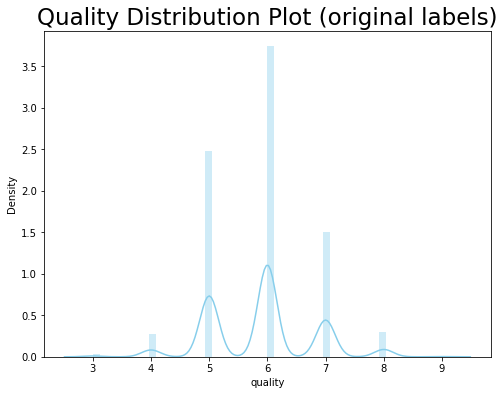

quality
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
dtype: float64

In [387]:
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (original labels)',fontsize=23)
sns.distplot(dataset['quality'], color='skyblue')
plt.show()

dataset.groupby('quality').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

As we don't have a good distribution of labels, we will reduce their number. Let's try to reduce the labels' number to 3:
- 0 if quality is less or equal to 5
- 1 if quality is equal to 6
- 2 if quality is greater than 6.

We see that we have a much better distribution of wines to labels.

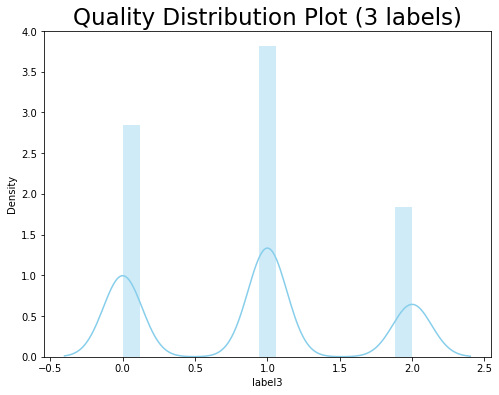

label3
0    0.334831
1    0.448755
2    0.216415
dtype: float64

In [388]:
dataset['label3'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else (1 if row['quality'] == 6 else 2), axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (3 labels)',fontsize=23)
sns.distplot(dataset['label3'], color='skyblue')
plt.show()

dataset.groupby('label3').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

Last but not least, let's try to reduce the label's number to 2:
- 0 if quality is less or equal to 5
- 1 if quality is greater or equal to 6

We see that we have a more uneven distribution. Maybe it is better to keep the 3 labels.

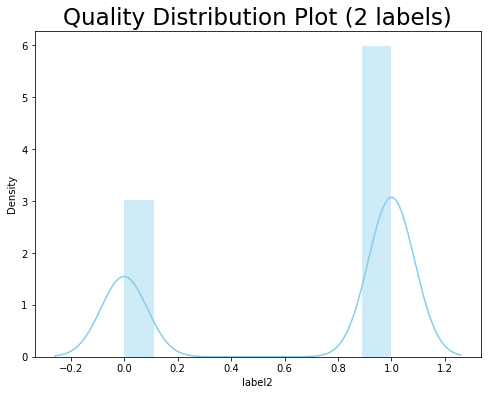

label2
0    0.334831
1    0.665169
dtype: float64

In [389]:
dataset['label2'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else 1, axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (2 labels)',fontsize=23)
sns.distplot(dataset['label2'], color='skyblue')
plt.show()

dataset.groupby('label2').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

# 2. Running kMeans and tuning hyperparameters
We will run kMeans with different values of k (1 - 30) and with different initialization methods (k-means++, random).\

In order to produce the best posible results, we will increase n_init parameter to perform more runs and select the ones with optimal errors.


First, we prepare the data for clustering.

In [390]:
from sklearn.preprocessing import StandardScaler


features = dataset.drop(['quality', 'label2', 'label3'], axis=1)
feature_names = features.columns
features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features, columns=feature_names)

wine_labels_2 = dataset['label2']
wine_labels_3 = dataset['label3']
wine_labels_7 = dataset['quality']

Then we will perform grid search in order to find the appropriate k and init method for the kMeans algorithm.

We will evaluate kMeans performance using the following:
- The Elbow method
- Silhouette Score
- Homogenity / Completeness agains true labels for the case of 2, 3 and 7 labels.

In [391]:
from tqdm.notebook import tqdm
from time import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics

n_clusters_values = range(1, 31)
init_values = ['k-means++', 'random']

progress_bar = tqdm(total=len(n_clusters_values) * len(init_values))
wcss = {init:[] for init in init_values}
silhouette_score = {init:[] for init in init_values}
fit_time = {init:[] for init in init_values}
v_measure_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
homogeneity_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
completeness_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
mean_v_measure_score = {init:[] for init in init_values}
for init in init_values:
    for n_clusters in n_clusters_values:
        results = {}
        kmeans = KMeans(n_clusters=n_clusters,
                        init=init, random_state=42)
        t0 = time()
        kmeans.fit(features)
        fit_time[init].append(time() - t0)
        wcss[init].append(kmeans.inertia_)
        silhouette_score[init].append(None if n_clusters == 1 else metrics.silhouette_score(features,
                                                                                            kmeans.labels_,
                                                                                            metric="euclidean",
                                                                                            sample_size=300))
        v_measure_score['labels_2'][init].append(metrics.v_measure_score(
            wine_labels_2, kmeans.labels_))
        v_measure_score['labels_3'][init].append(metrics.v_measure_score(
            wine_labels_3, kmeans.labels_))
        v_measure_score['labels_7'][init].append(metrics.v_measure_score(
            wine_labels_7, kmeans.labels_))
        mean_v_measure_score[init].append(np.mean([v[init][-1] for v in v_measure_score.values()]))
        homogeneity_score['labels_2'][init].append(metrics.homogeneity_score(
            wine_labels_2, kmeans.labels_))
        homogeneity_score['labels_3'][init].append(metrics.homogeneity_score(
            wine_labels_3, kmeans.labels_))
        homogeneity_score['labels_7'][init].append(metrics.homogeneity_score(
            wine_labels_7, kmeans.labels_))
        completeness_score['labels_2'][init].append(metrics.completeness_score(
            wine_labels_2, kmeans.labels_))
        completeness_score['labels_3'][init].append(metrics.completeness_score(
            wine_labels_3, kmeans.labels_))
        completeness_score['labels_7'][init].append(metrics.completeness_score(
            wine_labels_7, kmeans.labels_))
        progress_bar.update(1)

  0%|          | 0/60 [00:00<?, ?it/s]

In [392]:
def plot_clustering_metrics(ax, title, y_axis, x_axis, values, n_clusters_values):
    ax.set_xticks(n_clusters_values)
    for key in values:
        ax.plot(n_clusters_values, values[key])
    ax.set_title(title)
    ax.set(xlabel=x_axis, ylabel=y_axis)
    ax.grid()
    ax.legend(values.keys())

### Selecting the initialization method
As expected, selecting initial centroids using the k-means++ method (as described by Arthur, D. and Vassilvitskii, S. in “k-means++: the advantages of careful seeding paper) did not have any effect in performance. However, the results that I received were in contrast with the ones described in the paper. I did not see any improvement in the performance of the kMeans algorithm. On the contrast, random inialization had lower fit times. I am not aware why this happened. It could be the case that the wine dataset is too small and the performance uplift cannot exceed the k-means++ overhead cost and therefore the total fit time is worse, when compared to random centroid initialization.


### Selectintg the right cluster number
1. The Elbow Method: There is a clear "elbow" in the graph, which indicates k=2,3,4 as the best cluste values. Why? Because we see that the squared error of the distances of the points from their cluster center rapidly decreases until k=4. After k=4 the error still decreases, however, at a slow pace. Therefore, it seems that it does not worth to increase the cluster number further as the benefit in error reduction is negligible.
2. The Silhouette Score: I did not expect the results I got from the silhouette score: the score decreases as the number of clusters increases. Silhouette score represents how far is each point from the points of the same cluster vs how far it is from the points of all other clusters. This means that as the clusters increase, the selectd points cannot form clear groups. The best performing silhouette values are for k=2 (~0.5), k=3,4 (~0.4). After k=4 silhouette score drops significantly.

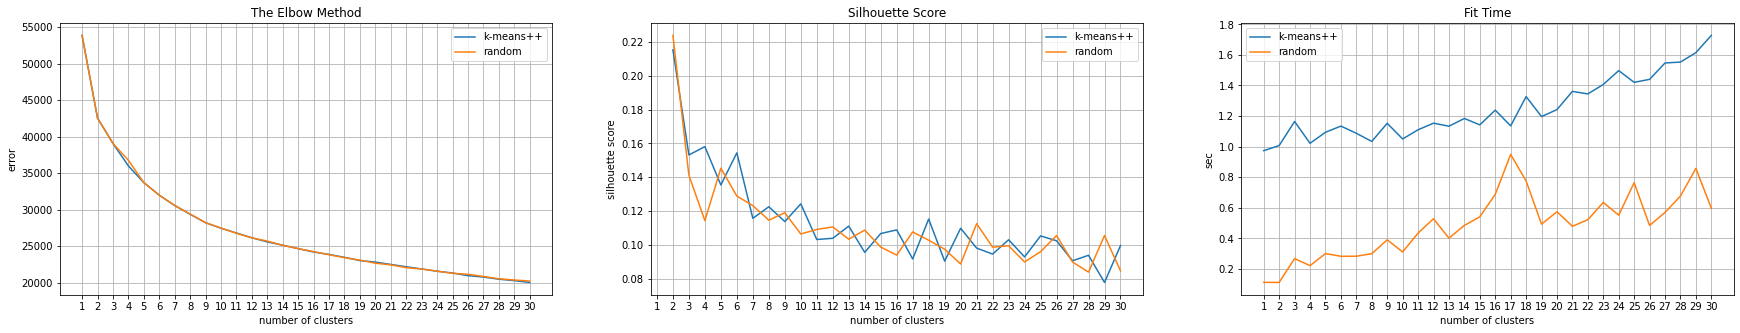

In [393]:
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'The Elbow Method', 'error', 'number of clusters', wcss, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette_score, n_clusters_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of clusters', fit_time, n_clusters_values)

As the decreasing Silhouette score confused me, I investigated furter. I run kMeans algorithm witch much more clusters (up to 4000 clusters). This way I would reduce significantly the number of points that would be included in each cluster (the biggest cluster contained just 8 points), hoping to receive better sihouette scores. However this wasn't the case. Silhouette score kept decreasing. I cannot explain this.

In [394]:
# n_clusters_values_further_investigation = range(1, 4000, 100)
# init_values_further_investigation = ['random']

# progress_bar = tqdm(total=len(n_clusters_values_further_investigation) * len(init_values_further_investigation))
# silhouette_score_further_investigation = {init:[] for init in init_values}
# for init in init_values_further_investigation:
#     for n_clusters in n_clusters_values_further_investigation:
#         results = {}
#         kmeans_further_investigation = KMeans(n_clusters=n_clusters,
#                         init=init, random_state=42)
#         kmeans_further_investigation.fit(features)
#         silhouette_score_further_investigation[init].append(None if n_clusters == 1 else metrics.silhouette_score(wine_features,
#                                                                                             kmeans.labels_,
#                                                                                             metric="euclidean",
#                                                                                             sample_size=300))
#         progress_bar.update(1)


In [395]:
# _, ax = plt.subplots(1, 1, figsize=(30, 2))
# plot_clustering_metrics(ax, 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette_score_further_investigation, n_clusters_values_further_investigation)

In [396]:
# labels_3900 = pd.DataFrame(kmeans_further_investigation.labels_, columns=['cluster'])
# labels_3900.groupby('cluster').size().max()

It is clear that the graphs indicate k=2,3,4 as good candidates for cluster sizes. However, one alternative approach in selecting cluster size is to take into consideration the real-world case we are dealing with. As the wine datased is already labeled, why not select a k that corresponds to the label count? As discussed, apart from the 7 quality lablels, I created two extra ways of labeling wines, by combining different labels.
will rely k selection on the Elbow method scores.

I didn't get the results I expected. I expected to see better performance when using k=the number of real labels. This means that I expected to see good performance for k=2 when having only 2 labels, for k=3 when having 3 labels and k=7 when having 7 labels. What I found is the following:
- Homogeneity score incrases as number of clusters increase, which makes sense, as having more clusters means that the probability of having two points of different real label in the same cluster decreases.
- Completeness score is maximum for k=2 then drops significantly and then it stabilizes. It seems that when having two clusters, there is some (small) consistency in the way real labels are distributed to the clusters. kMeans seems to be unable to identify the logic that the wine tasters used in order to classify the wines. Even if the number of clusters increase, there is no impact on completeness.

So what cluster size shall we use? As kMeans didn't manage to assign meaningful labels (in terms of wine quality), I relied on the Elbow method and silhouette score in order to select the cluster size. So I selected k=3.


In [ ]:
K_MEANS_INIT = 'random'

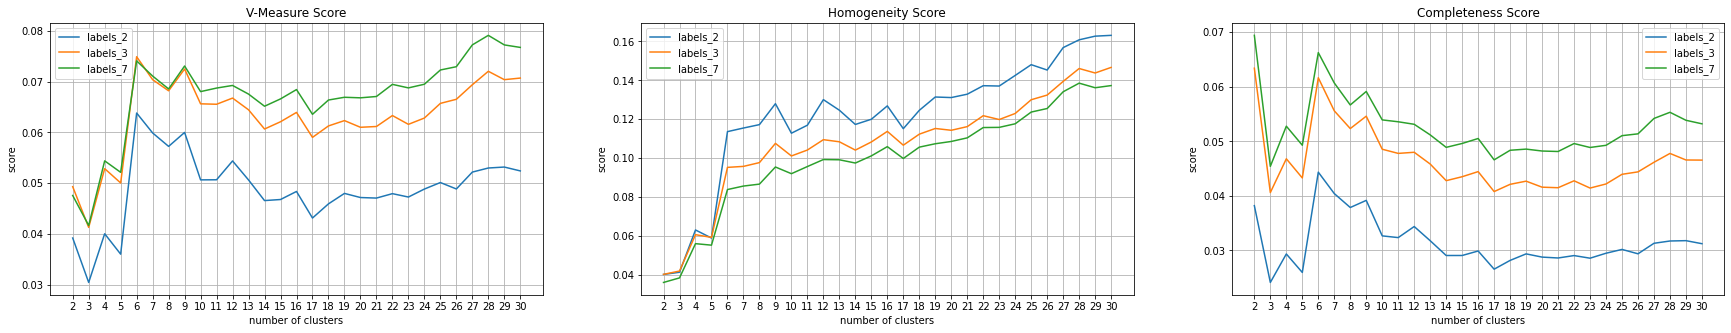

In [397]:
v_measure_score_plot = {label:v_measure_score[label]['random'][1:] for label in v_measure_score.keys()}
homogeneity_score_plot = {label:homogeneity_score[label]['random'][1:] for label in homogeneity_score.keys()}
completeness_score_plot = {label:completeness_score[label]['random'][1:] for label in completeness_score.keys()}
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'V-Measure Score', 'score', 'number of clusters', v_measure_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[1], 'Homogeneity Score', 'score', 'number of clusters', homogeneity_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[2], 'Completeness Score', 'score', 'number of clusters', completeness_score_plot, n_clusters_values[1:])

In [398]:
K_MEANS_CLUSTERS = 6

The poor clustering results can be partially explained when the 11 features of the dataset are projected to 2 dimensions: there is no clear separation of the real labels of the dataset.

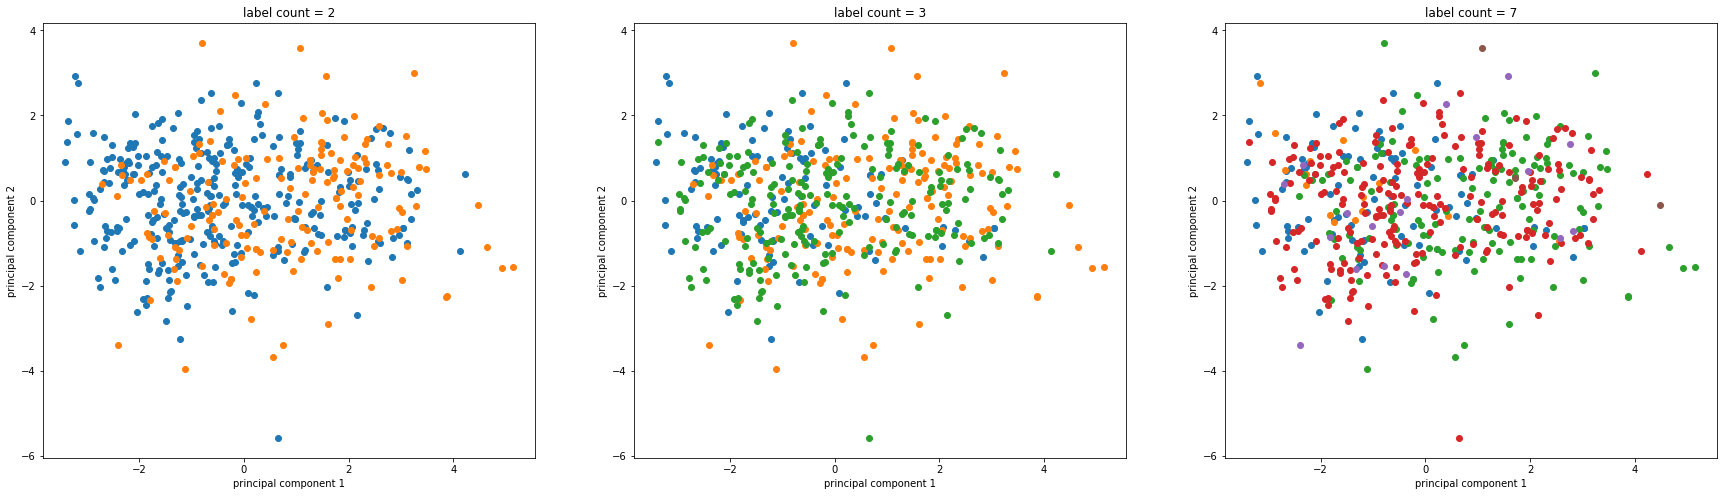

In [399]:
from sklearn.decomposition import PCA
np.random.seed(42)

pca_2d = PCA(n_components=2, random_state=42)
principal_components_2d = pca_2d.fit_transform(features)
principal_components_2d = pd.DataFrame(principal_components_2d, columns=[
                                       'principal component 1', 'principal component 2'])
principal_components_2d['label_2'] = wine_labels_2
principal_components_2d['label_3'] = wine_labels_3
principal_components_2d['label_7'] = wine_labels_7

_, ax = plt.subplots(1, 3, figsize=(30, 8))
principal_components_2d = principal_components_2d.sample(500)
label_types = ['label_2', 'label_3', 'label_7']
for index, label in enumerate(label_types):
    ax[index].set(xlabel='principal component 1', ylabel='principal component 2')
    ax[index].set_title(' count = '.join(label.split("_")))
    for value in principal_components_2d[label].unique():
        indices_to_keep = principal_components_2d[label] == value
        ax[index].scatter(principal_components_2d.loc[indices_to_keep, 'principal component 1'],
                    principal_components_2d.loc[indices_to_keep, 'principal component 2'])
plt.show()


Then, I performed dimensionality reduction using PCA. The basic metric I used to evaluate the resuls was the retained variance. I performed PCA for different values of retained variance (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99) and I monitored the number of principal components as well as the mean squared error between the original features and the re-constructed features after the transformation.
The results were as expected: The more the dimensions are reduced, the more the error increases and the retained variance decreases.

One interesting finding was that reducing the components by 1 has almost zero impact in the quality of the data (mse~=0.002). Even in the case where dimensions are reduced by 2 or 3 (which corresponds to 95% and 90% of retained variance) mse is very low (less than 0.1).

In order to make sure that dimensionality reduction will not have a negative impact in accuracy, I chose n_components=9 as the number of reduced dimensions.

,number of principal components,mse,variance retained
0,1,0.707068,0.20
1,2,0.563864,0.40
2,3,0.452803,0.50
3,4,0.360210,0.60
4,5,0.271725,0.70
5,6,0.186385,0.80
6,7,0.120331,0.85
7,8,0.065844,0.90
8,9,0.028194,0.95
9,10,0.001877,0.99


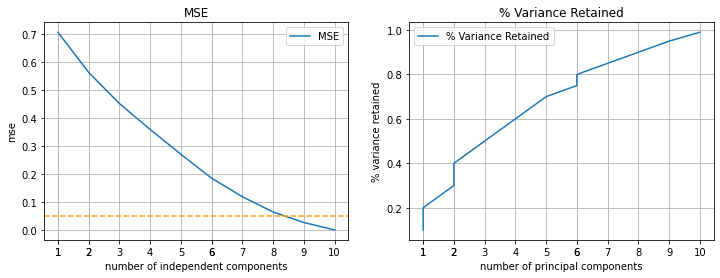

In [400]:
from sklearn.decomposition import PCA

variance_retained_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
pca_mse = []
n_components = []
for variance_retained in variance_retained_values:
    pca = PCA(n_components=variance_retained,
              svd_solver='full', random_state=42)
    principal_components = pca.fit_transform(features)
    n_components.append(np.shape(principal_components)[1])
    reconstructed_features = pca.inverse_transform(principal_components)
    mse = np.mean((np.square(reconstructed_features - features).mean(axis=0)))
    pca_mse.append(mse)

_, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_clustering_metrics(ax[0], 'MSE', 'mse', 'number of independent components', {'MSE': pca_mse}, n_components)
ax[0].axhline(0.05, linestyle='--', color='orange')
plot_clustering_metrics(ax[1], '% Variance Retained', '% variance retained', 'number of principal components', {'% Variance Retained': variance_retained_values}, n_components)

pca_measurements = pd.DataFrame({'mse': pca_mse, 'variance retained': variance_retained_values, 'number of principal components': n_components}).groupby('number of principal components').max('variance retained').reset_index().sort_values('number of principal components')
pca_measurements

In [411]:
PCA_COMPONENTS = int(pca_measurements[pca_measurements.mse < 0.1].iloc[0,:]['number of principal components'])

print(f'Number of principal components selected: {PCA_COMPONENTS}')


Number of principal components selected: 8


Then, I performed dimensionality reduction using PCA. The basic metric I used to evaluate the resuls was kurtosis. I performed ICA for different number of independent components and I monitored the difference of mean kurtosis vs the mean kurtosis of the original dataset as well as the mean squared error between the original features and the re-constructed features after the transformation.
As far as the error is concerned, the results were as expected: the more the dimensions are reduced, the more the error increases.
What was impressive was kurtosis. The kurtosis of independend components matches the original distribution's kurtosis for component values 6-8 and not higher. Also, there is a peak of kurtosis when components=11. I believe that this is a random mistake due to the fact that kurtosis is very sensitive to outliers. Most probably if I changed the randomness seed there would be an outlier for some other value of number of components. Independent component interpretation confuses me a bit, but from what I understand as we achieve good kurtosis for less components, it means that the initial dataset contains some features that just represent noise and they are not that useful and that can be ignored.

In order to balance between error and kurtosis, I selected n_components=7 as the number of reduced dimensions.

  0%|          | 0/11 [00:00<?, ?it/s]

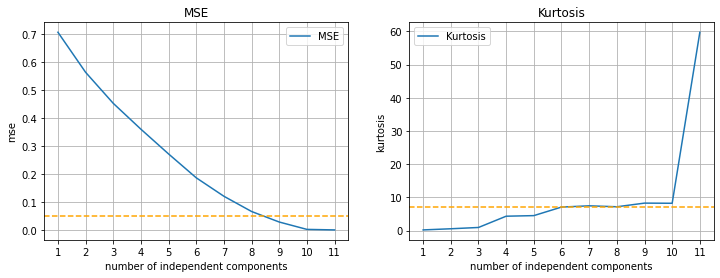

,number of independent components,mse,kurtosis,kurtosis difference from original
0,1,7.070678e-01,0.207054,6.986151
1,2,5.638642e-01,0.553607,6.639599
2,3,4.528032e-01,0.944000,6.249205
3,4,3.602102e-01,4.336309,2.856897
4,5,2.717253e-01,4.514211,2.678994
5,6,1.863851e-01,7.085016,0.108190
6,7,1.203308e-01,7.466978,0.273773
7,8,6.584363e-02,7.180593,0.012612
8,9,2.819420e-02,8.280026,1.086821
9,10,1.877190e-03,8.234091,1.040886


In [412]:
from sklearn.decomposition import FastICA

n_components_values = range(1, features.shape[1] + 1)
ica_mse = []
kurtosis = []
progress_bar = tqdm(total=len(n_components_values))
for n_components in n_components_values:
    ica = FastICA(n_components=n_components, whiten=True, random_state=42)
    independent_components = ica.fit_transform(features)
    reconstructed_features = ica.inverse_transform(independent_components)
    mse = np.mean((np.square(reconstructed_features - features).mean(axis=0)))
    ica_mse.append(mse)
    independent_components = pd.DataFrame(independent_components)
    kurtosis.append(independent_components.kurt(axis=0).abs().mean())
    progress_bar.update(1)

original_kurtosis = pd.DataFrame(features).kurt(axis=0).abs().mean()
_, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_clustering_metrics(ax[0], 'MSE', 'mse', 'number of independent components', {'MSE':ica_mse}, n_components_values)
ax[0].axhline(0.05, linestyle='--', color='orange')
plot_clustering_metrics(ax[1], 'Kurtosis', 'kurtosis', 'number of independent components', {'Kurtosis':kurtosis}, n_components_values)
ax[1].axhline(original_kurtosis, linestyle='--', color='orange')
plt.show()

ica_measurements = pd.DataFrame({'mse': ica_mse, 'kurtosis': kurtosis, 'number of independent components': n_components_values, 'kurtosis difference from original': np.abs(kurtosis - original_kurtosis)}).groupby('number of independent components').min('kurtosis difference from original').reset_index().sort_values('number of independent components')
ica_measurements

In [413]:
ICA_COMPONENTS = int(ica_measurements[ica_measurements['kurtosis difference from original'] < 0.3].groupby('number of independent components').min('mse').sort_values('mse').reset_index().iloc[0,:]['number of independent components'])
print(f'Number of independent components selected: {ICA_COMPONENTS}')

Number of independent components selected: 8


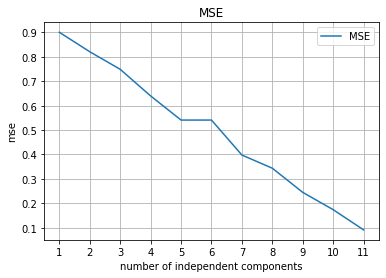

In [414]:
from sklearn.random_projection import SparseRandomProjection

n_components_values = range(1, features.shape[1] + 1)

mses = []
density = []
for n_components in n_components_values:
    rp = SparseRandomProjection(n_components=n_components, random_state=42)
    random_components = rp.fit_transform(features)
    transformation_matrix = rp.components_.toarray()
    inverse_transformation_matrix = np.linalg.pinv(transformation_matrix.T)
    reconstructed_features = random_components.dot(inverse_transformation_matrix)
    mses.append(np.mean((np.square(reconstructed_features - features).mean(axis=0))))
    density.append(rp.density_)

_, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_clustering_metrics(ax, 'MSE', 'mse', 'number of independent components', {'MSE':mses}, n_components_values)


In [415]:
RANDOM_PROJECTION_COMPONENTS = 8

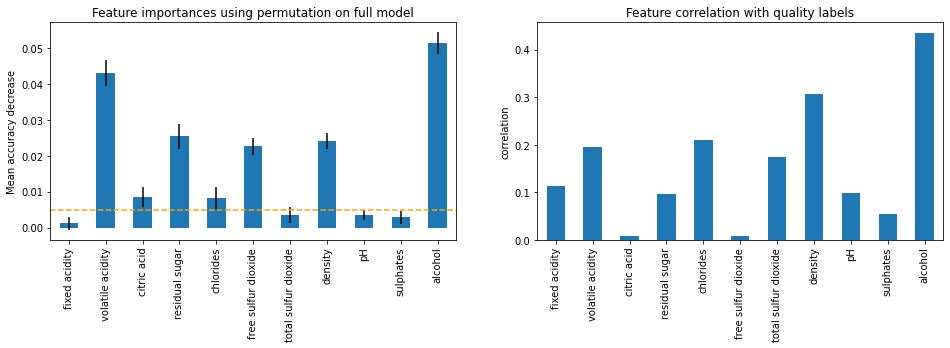

In [416]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance

ensemble = AdaBoostClassifier(n_estimators=100, random_state=42)
ensemble.fit(features, wine_labels_2)

result = permutation_importance(ensemble, features, wine_labels_2, n_repeats=10, random_state=42, n_jobs=2)

feature_importances = pd.Series(result.importances_mean, index=features.columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
feature_importances.plot.bar(yerr=result.importances_std, ax=ax[0])
ax[0].set_title("Feature importances using permutation on full model")
ax[0].set_ylabel("Mean accuracy decrease")
ax[0].axhline(0.005, linestyle='--', color='orange')

ax[1].set_title("Feature correlation with quality labels")
ax[1].set_ylabel("correlation")
feature_correlation = dataset[dataset.columns[:-2]].corr()['quality'].abs()
feature_correlation[feature_correlation.index != 'quality'].plot.bar(ax=ax[1])
plt.show()

In [417]:
import pprint
importances_mean = pd.DataFrame(result.importances_mean, index=features.columns, columns=['importance mean'])
important_features = importances_mean[importances_mean['importance mean'] >= 0.005]
print('Important features based on AdaBoost Classifier:')
pprint.pprint(list(important_features.index), indent=3)
ENSEMBLE_IMPORTANT_FEATURES = list(important_features.index)

Important features based on AdaBoost Classifier:
[  'volatile acidity',
   'citric acid',
   'residual sugar',
   'chlorides',
   'free sulfur dioxide',
   'density',
   'alcohol']


In [515]:
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(features)
ica = FastICA(n_components=ICA_COMPONENTS, whiten=True, random_state=42)
ica_features = ica.fit_transform(features)
rp = SparseRandomProjection(
    n_components=RANDOM_PROJECTION_COMPONENTS, random_state=42)
rp_features = rp.fit_transform(features)
important_features = features[ENSEMBLE_IMPORTANT_FEATURES].values

transformed_features_list = [features.values, pca_features,
                             ica_features, rp_features, important_features]

feature_count = [len(f[0]) for f in transformed_features_list]
fit_time = np.zeros(len(transformed_features_list))
wcss = []
v_measure_score = []
silhouette_score = []
homogeneity_score = []
completeness_score = []
TIME_TESTS = 20
progress_bar = tqdm(total=len(transformed_features_list) * TIME_TESTS)
clustering_labels = []
for iteration in range(TIME_TESTS):
    for index, transformed_features in enumerate(transformed_features_list):
        kmeans = KMeans(n_clusters=K_MEANS_CLUSTERS, init=K_MEANS_INIT, random_state=42)
        t0 = time()
        kmeans.fit(transformed_features)
        clustering_labels.append(kmeans.labels_)
        fit_time[index] += time() - t0
        if iteration == 0:
            wcss.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(features,
                                                                kmeans.labels_,
                                                                metric="euclidean",
                                                                sample_size=300))
            v_measure_score.append(metrics.v_measure_score(
                wine_labels_2, kmeans.labels_))

            homogeneity_score.append(metrics.homogeneity_score(
                wine_labels_2, kmeans.labels_))

            completeness_score.append(metrics.completeness_score(
                wine_labels_2, kmeans.labels_))
        progress_bar.update(1)

fit_time = np.divide(fit_time, TIME_TESTS)


  0%|          | 0/100 [00:00<?, ?it/s]

In [516]:
kmeans_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'wcss': wcss,
        'silhouette score': silhouette_score,
        'v measure score': v_measure_score,
        'homogeneity score': homogeneity_score,
        'completeness score': completeness_score,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
kmeans_metrics

,number of components,fit time,wcss,silhouette score,v measure score,homogeneity score,completeness score
original,11,0.272077,31971.457874,0.141188,0.063801,0.113664,0.044346
PCA,8,0.308476,28666.628604,0.125590,0.058391,0.104254,0.040552
ICA,8,0.182160,5.317382,0.102837,0.038340,0.069029,0.026540
Random Projection,8,0.219075,17284.134453,0.064809,0.063872,0.117546,0.043849
Important Features,7,0.174559,15998.763925,0.120531,0.066379,0.114801,0.046686


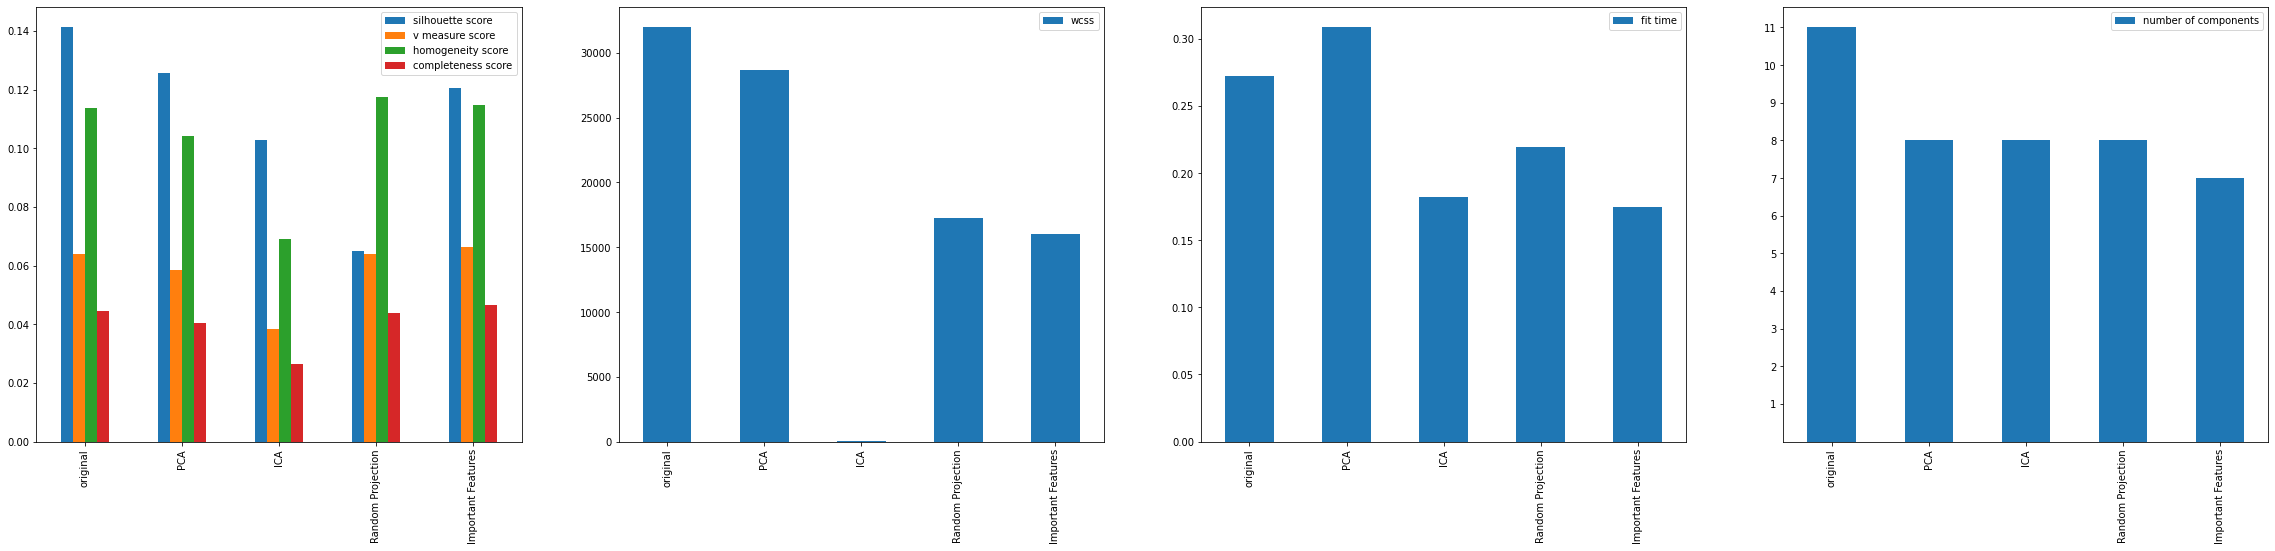

In [517]:

fig, ax = plt.subplots(1, 4, figsize=(40, 8))
kmeans_metrics.plot.bar(y=['silhouette score', 'v measure score', 'homogeneity score', 'completeness score'], ax=ax[0])
kmeans_metrics.plot.bar(y='wcss', ax=ax[1])
kmeans_metrics.plot.bar(y='fit time', ax=ax[2])
ax[3].set_yticks(range(1, kmeans_metrics['number of components'].max() + 1))
kmeans_metrics.plot.bar(y='number of components', ax=ax[3])
plt.show()

In [518]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, wine_labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))   


In [519]:
neural_network_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,2.493030,0.983372,0.803401
PCA,8,3.607940,0.946616,0.793197
ICA,8,4.026294,0.799300,0.763265
Random Projection,8,3.633318,0.948658,0.751020
Important Features,7,2.528234,0.946324,0.788435


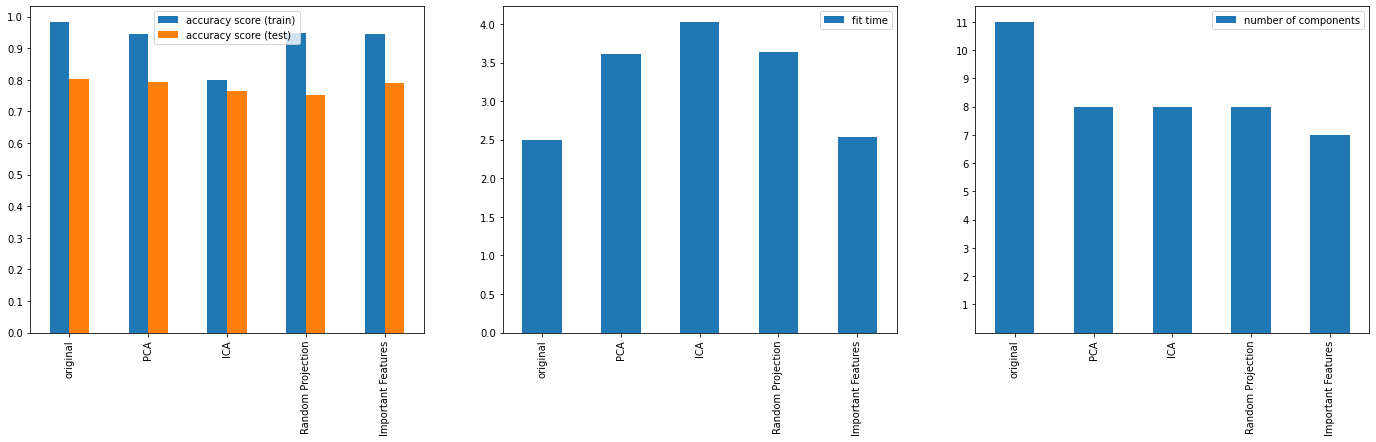

In [520]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0])
neural_network_metrics.plot.bar(y='fit time', ax=ax[1])
ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
neural_network_metrics.plot.bar(y='number of components', ax=ax[2])
plt.show()

In [521]:
transformed_features_list = [pd.DataFrame(transformed_features) for transformed_features in transformed_features_list]
for transformed_features, labels in zip(transformed_features_list, clustering_labels):
    transformed_features['k-means clustering labels'] = labels
transformed_features_list = [transformed_features.values for transformed_features in transformed_features_list]


In [522]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, wine_labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))  

In [523]:
neural_network_with_labels_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_with_labels_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,3.797840,0.964994,0.781633
PCA,8,2.313200,0.957118,0.778231
ICA,8,2.302874,0.771879,0.763946
Random Projection,8,3.282580,0.926779,0.756463
Important Features,7,3.279873,0.914236,0.774150


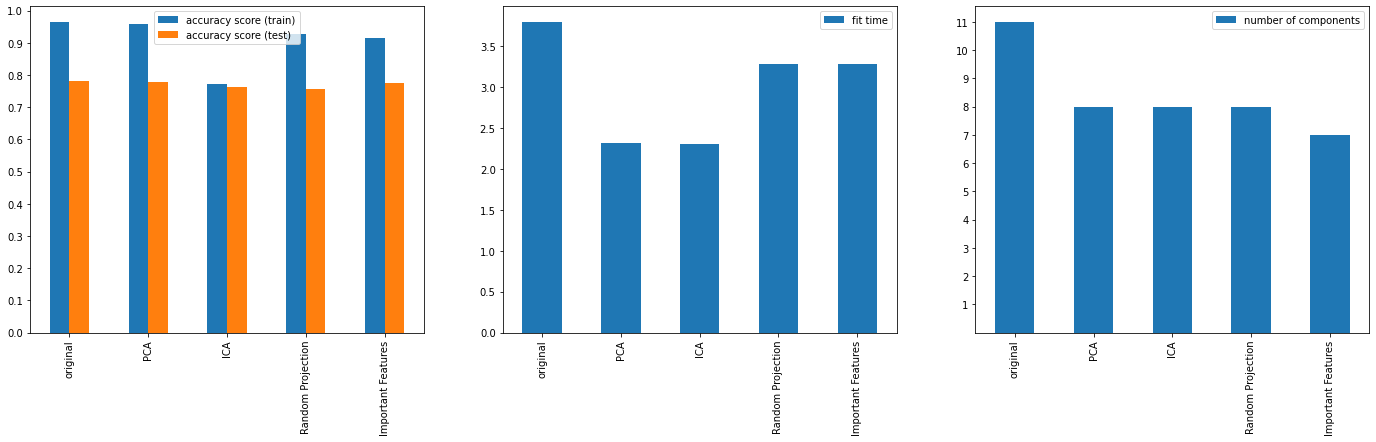

In [524]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_with_labels_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0])
neural_network_with_labels_metrics.plot.bar(y='fit time', ax=ax[1])
ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
neural_network_with_labels_metrics.plot.bar(y='number of components', ax=ax[2])
plt.show()

In [530]:
neural_network_comparison = pd.DataFrame(
    {
        'fit time': neural_network_metrics['fit time'],
        'fit time - k-means labels': neural_network_with_labels_metrics['fit time'],
        'accuracy score (train)': neural_network_metrics['accuracy score (train)'],
        'accuracy score (train) - k-means labels': neural_network_with_labels_metrics['accuracy score (train)'],
        'accuracy score (test)': neural_network_metrics['accuracy score (test)'],
        'accuracy score (test) - k-means labels': neural_network_with_labels_metrics['accuracy score (test)']
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features']
)
neural_network_comparison


,fit time,fit time - k-means labels,accuracy score (train),accuracy score (train) - k-means labels,accuracy score (test),accuracy score (test) - k-means labels
original,2.493030,3.797840,0.983372,0.964994,0.803401,0.781633
PCA,3.607940,2.313200,0.946616,0.957118,0.793197,0.778231
ICA,4.026294,2.302874,0.799300,0.771879,0.763265,0.763946
Random Projection,3.633318,3.282580,0.948658,0.926779,0.751020,0.756463
Important Features,2.528234,3.279873,0.946324,0.914236,0.788435,0.774150


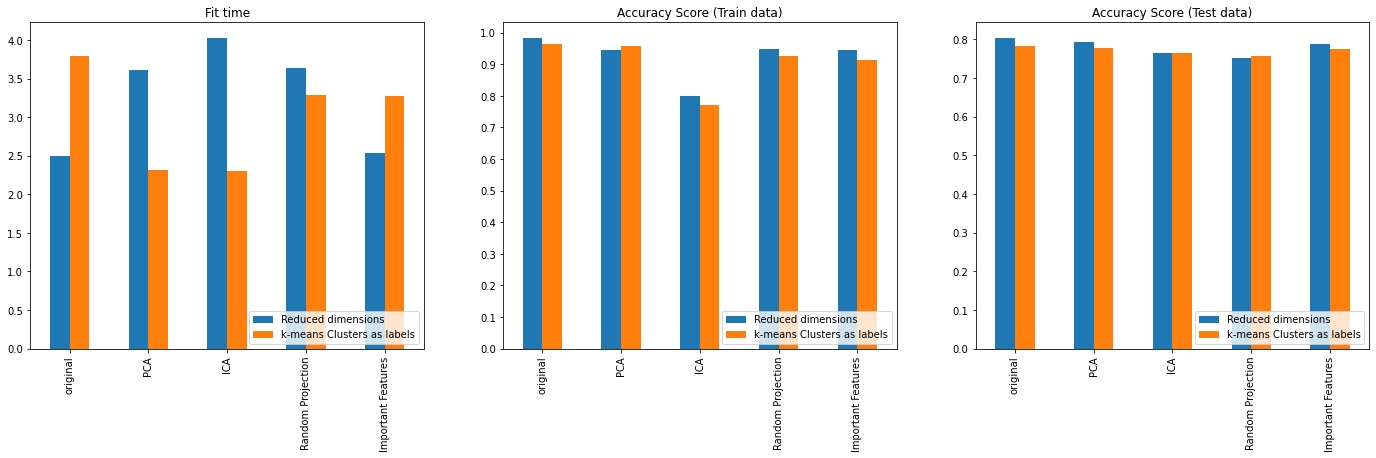

In [541]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
neural_network_comparison.plot.bar(y=['fit time', 'fit time - k-means labels'], ax=ax[0], title='Fit time')
ax[0].legend(['Reduced dimensions', 'k-means Clusters as labels'], loc=4)
ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (train)', 'accuracy score (train) - k-means labels'], ax=ax[1], title='Accuracy Score (Train data)')
ax[1].legend(['Reduced dimensions', 'k-means Clusters as labels'], loc=4)
ax[2].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (test)', 'accuracy score (test) - k-means labels'], ax=ax[2], title='Accuracy Score (Test data)')
ax[2].legend(['Reduced dimensions', 'k-means Clusters as labels'], loc=4)
plt.show()

References:
- Arthur, D. and Vassilvitskii, S. “k-means++: the advantages of careful seeding: https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf